In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import talib as ta
import mplfinance as mpl
import backtrader as bt

###Download the index and stock data

nifty_index = yf.download("^NSEI", start = "2012-01-01", end = "2022-06-22")

SBIN = yf.download("SBIN.NS", start = "2012-01-01", end = "2022-06-22")
RELIANCE = yf.download("RELIANCE.NS", start = "2012-01-01", end = "2022-06-22")
INFY = yf.download("INFY.NS", start = "2012-01-01", end = "2022-06-22")
TCS = yf.download("TCS.NS", start = "2012-01-01", end = "2022-06-22")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


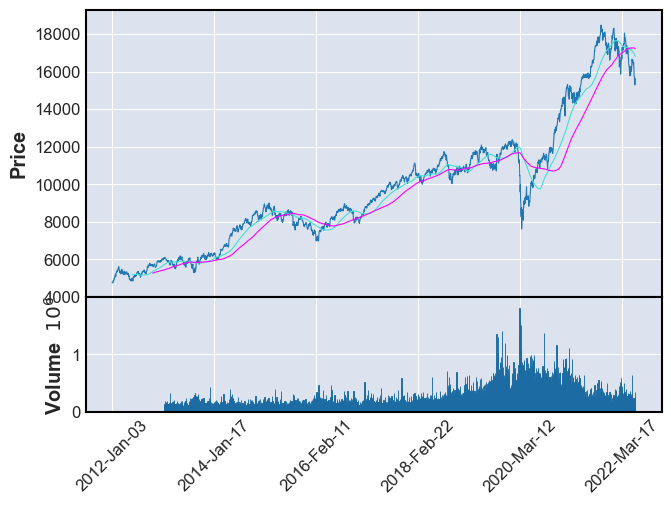

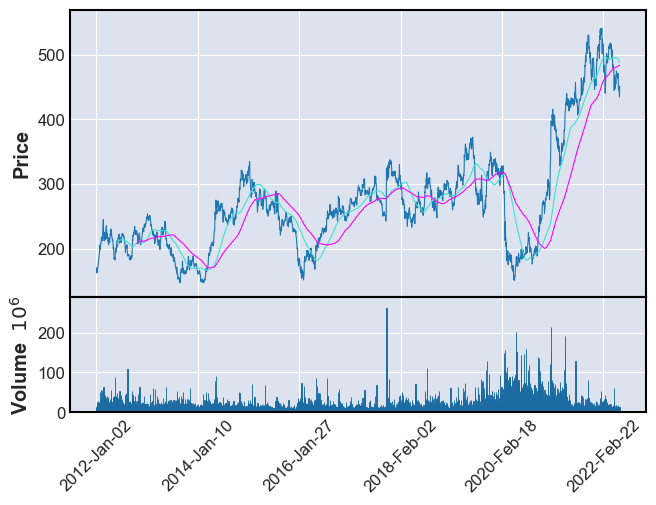

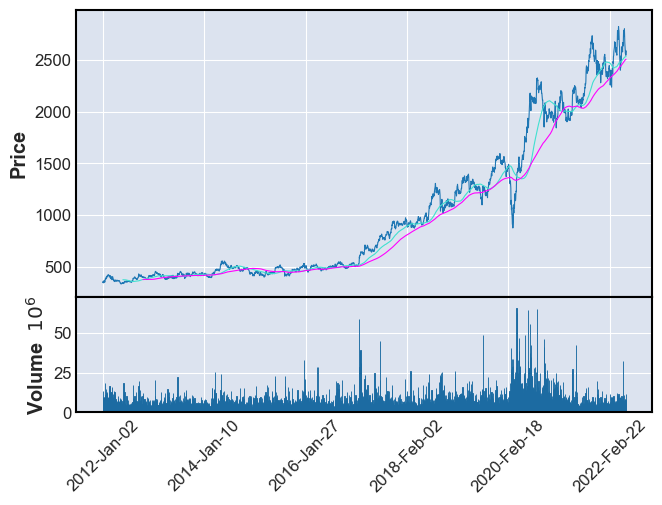

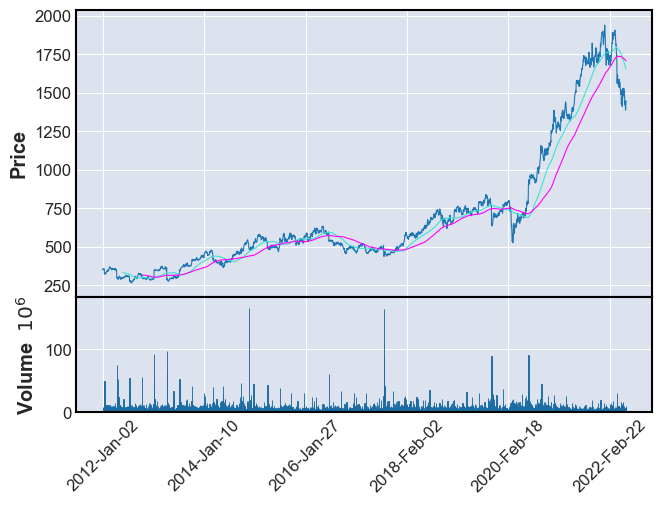

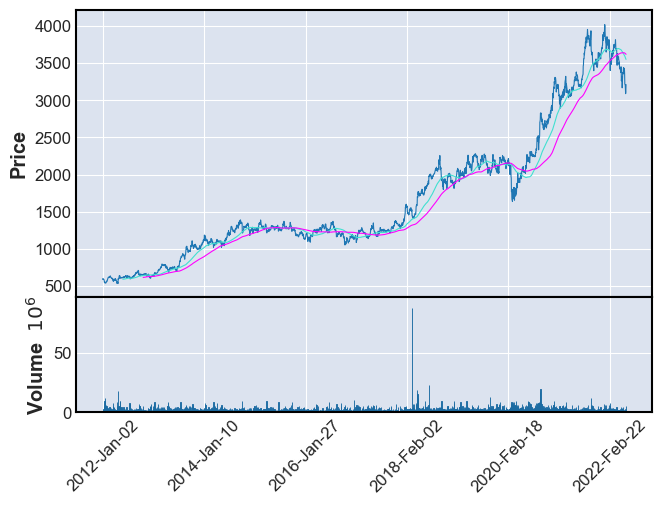

In [5]:
#Visualize the index timeseries
mpl.plot(nifty_index, type = 'line', mav = (100,200), volume = True)
mpl.plot(SBIN, type = 'line', mav = (100,200), volume = True)
mpl.plot(RELIANCE, type = 'line', mav = (100,200), volume = True)
mpl.plot(INFY, type = 'line', mav = (100,200), volume = True)
mpl.plot(TCS, type = 'line', mav = (100,200), volume = True)

In [6]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [7]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    cerebro.addobserver(bt.observers.Value)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.Returns)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    
    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    # Create a Data Feed
    data = bt.feeds.PandasData(dataname = nifty_index)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000000.0)

    # Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.003)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    result = cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    

Starting Portfolio Value: 1000000.00
2012-01-03, Close, 4765.30
2012-01-04, Close, 4749.65
2012-01-04, BUY CREATE, 4749.65
2012-01-05, BUY EXECUTED, Price: 4749.00, Cost: 4749.00, Comm 14.25
2012-01-05, Close, 4749.95
2012-01-06, Close, 4754.10
2012-01-09, Close, 4742.80
2012-01-10, Close, 4849.55
2012-01-11, Close, 4860.95
2012-01-12, Close, 4831.25
2012-01-12, SELL CREATE, 4831.25
2012-01-13, SELL EXECUTED, Price: 4861.95, Cost: 4749.00, Comm 14.59
2012-01-13, OPERATION PROFIT, GROSS 112.95, NET 84.12
2012-01-13, Close, 4866.00
2012-01-16, Close, 4873.90
2012-01-17, Close, 4967.30
2012-01-18, Close, 4955.80
2012-01-19, Close, 5018.40
2012-01-20, Close, 5048.60
2012-01-23, Close, 5046.25
2012-01-24, Close, 5127.35
2012-01-25, Close, 5158.30
2012-01-27, Close, 5204.70
2012-01-30, Close, 5087.30
2012-01-31, Close, 5199.25
2012-02-01, Close, 5235.70
2012-02-02, Close, 5269.90
2012-02-03, Close, 5325.85
2012-02-06, Close, 5361.65
2012-02-07, Close, 5335.15
2012-02-08, Close, 5368.15
2012-

2014-05-08, SELL EXECUTED, Price: 6669.90, Cost: 6769.00, Comm 20.01
2014-05-08, OPERATION PROFIT, GROSS -99.10, NET -139.42
2014-05-08, Close, 6659.85
2014-05-09, Close, 6858.80
2014-05-12, Close, 7014.25
2014-05-13, Close, 7108.75
2014-05-14, Close, 7108.75
2014-05-15, Close, 7123.15
2014-05-16, Close, 7203.00
2014-05-19, Close, 7263.55
2014-05-20, Close, 7275.50
2014-05-21, Close, 7252.90
2014-05-22, Close, 7276.40
2014-05-23, Close, 7367.10
2014-05-26, Close, 7359.05
2014-05-27, Close, 7318.00
2014-05-27, BUY CREATE, 7318.00
2014-05-28, BUY EXECUTED, Price: 7324.95, Cost: 7324.95, Comm 21.97
2014-05-28, Close, 7329.65
2014-05-29, Close, 7235.65
2014-05-30, Close, 7229.95
2014-06-02, Close, 7362.50
2014-06-03, Close, 7415.85
2014-06-04, Close, 7402.25
2014-06-04, SELL CREATE, 7402.25
2014-06-05, SELL EXECUTED, Price: 7399.75, Cost: 7324.95, Comm 22.20
2014-06-05, OPERATION PROFIT, GROSS 74.80, NET 30.63
2014-06-05, Close, 7474.10
2014-06-06, Close, 7583.40
2014-06-09, Close, 7654.60

2016-11-29, Close, 8142.15
2016-11-30, Close, 8224.50
2016-12-01, Close, 8192.90
2016-12-02, Close, 8086.80
2016-12-02, BUY CREATE, 8086.80
2016-12-05, BUY EXECUTED, Price: 8088.75, Cost: 8088.75, Comm 24.27
2016-12-05, Close, 8128.75
2016-12-06, Close, 8143.15
2016-12-07, Close, 8102.05
2016-12-08, Close, 8246.85
2016-12-09, Close, 8261.75
2016-12-12, Close, 8170.80
2016-12-12, SELL CREATE, 8170.80
2016-12-13, SELL EXECUTED, Price: 8196.15, Cost: 8088.75, Comm 24.59
2016-12-13, OPERATION PROFIT, GROSS 107.40, NET 58.55
2016-12-13, Close, 8221.80
2016-12-14, Close, 8182.45
2016-12-15, Close, 8153.60
2016-12-15, BUY CREATE, 8153.60
2016-12-16, BUY EXECUTED, Price: 8178.20, Cost: 8178.20, Comm 24.53
2016-12-16, Close, 8139.45
2016-12-19, Close, 8104.35
2016-12-20, Close, 8082.40
2016-12-21, Close, 8061.30
2016-12-22, Close, 7979.10
2016-12-23, Close, 7985.75
2016-12-23, SELL CREATE, 7985.75
2016-12-26, SELL EXECUTED, Price: 7965.10, Cost: 8178.20, Comm 23.90
2016-12-26, OPERATION PROFIT,

2019-04-16, Close, 11787.15
2019-04-18, Close, 11752.80
2019-04-22, Close, 11594.45
2019-04-22, BUY CREATE, 11594.45
2019-04-23, BUY EXECUTED, Price: 11612.95, Cost: 11612.95, Comm 34.84
2019-04-23, Close, 11575.95
2019-04-24, Close, 11726.15
2019-04-25, Close, 11641.80
2019-04-26, Close, 11754.65
2019-04-30, Close, 11748.15
2019-05-02, Close, 11724.75
2019-05-02, SELL CREATE, 11724.75
2019-05-03, SELL EXECUTED, Price: 11722.60, Cost: 11612.95, Comm 35.17
2019-05-03, OPERATION PROFIT, GROSS 109.65, NET 39.64
2019-05-03, Close, 11712.25
2019-05-03, BUY CREATE, 11712.25
2019-05-06, BUY EXECUTED, Price: 11605.80, Cost: 11605.80, Comm 34.82
2019-05-06, Close, 11598.25
2019-05-07, Close, 11497.90
2019-05-08, Close, 11359.45
2019-05-09, Close, 11301.80
2019-05-10, Close, 11278.90
2019-05-13, Close, 11148.20
2019-05-13, SELL CREATE, 11148.20
2019-05-14, SELL EXECUTED, Price: 11151.65, Cost: 11605.80, Comm 33.45
2019-05-14, OPERATION PROFIT, GROSS -454.15, NET -522.42
2019-05-14, Close, 11222.

2021-08-17, Close, 16614.60
2021-08-18, Close, 16568.85
2021-08-20, Close, 16450.50
2021-08-20, BUY CREATE, 16450.50
2021-08-23, BUY EXECUTED, Price: 16592.25, Cost: 16592.25, Comm 49.78
2021-08-23, Close, 16496.45
2021-08-24, Close, 16624.60
2021-08-25, Close, 16634.65
2021-08-26, Close, 16636.90
2021-08-27, Close, 16705.20
2021-08-30, Close, 16931.05
2021-08-30, SELL CREATE, 16931.05
2021-08-31, SELL EXECUTED, Price: 16947.50, Cost: 16592.25, Comm 50.84
2021-08-31, OPERATION PROFIT, GROSS 355.25, NET 254.63
2021-08-31, Close, 17132.20
2021-09-01, Close, 17076.25
2021-09-02, Close, 17234.15
2021-09-03, Close, 17323.60
2021-09-06, Close, 17377.80
2021-09-07, Close, 17362.10
2021-09-08, Close, 17353.50
2021-09-08, BUY CREATE, 17353.50
2021-09-09, BUY EXECUTED, Price: 17312.85, Cost: 17312.85, Comm 51.94
2021-09-09, Close, 17369.25
2021-09-13, Close, 17355.30
2021-09-14, Close, 17380.00
2021-09-15, Close, 17519.45
2021-09-16, Close, 17629.50
2021-09-17, Close, 17585.15
2021-09-17, SELL C

<IPython.core.display.Javascript object>


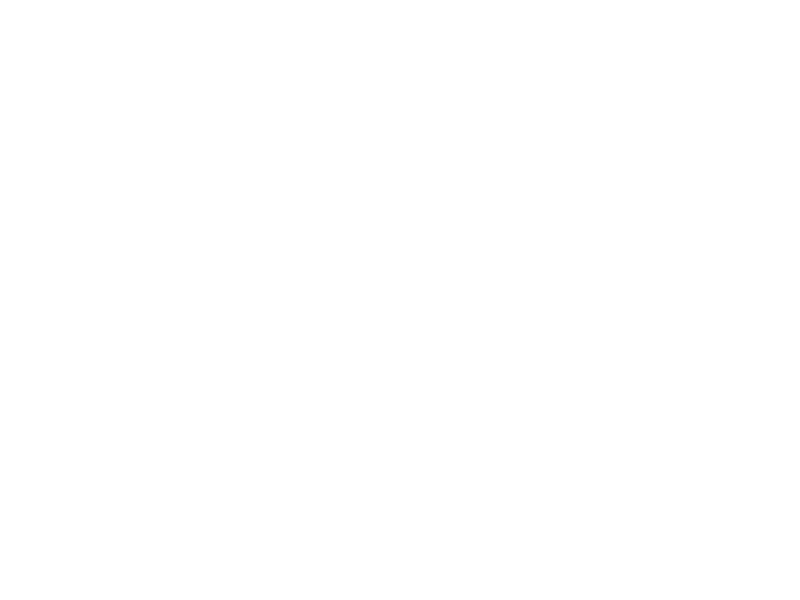

Sharpe: -1.051
Norm. Annual Return: -0.11%
Max Drawdown: 1.17%


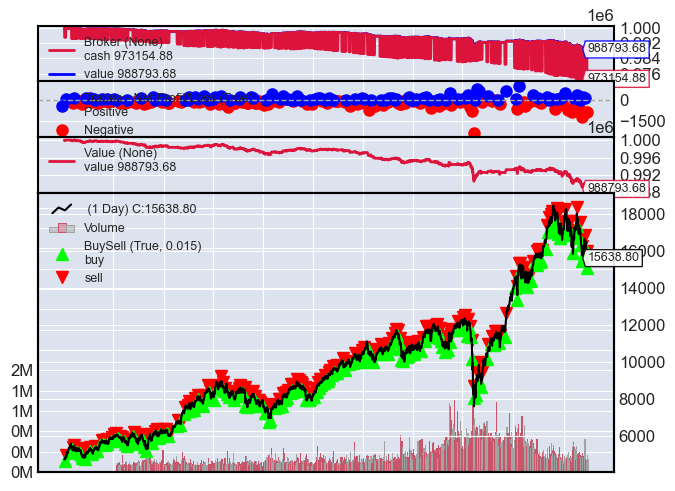

In [13]:
cerebro.plot()
print(f"Sharpe: {result[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
print(f"Norm. Annual Return: {result[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
print(f"Max Drawdown: {result[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")